# Teste Transferência de Calor

## Teste Incropera 5.124

In [9]:
import numpy
import scipy
from math import pi, fabs, log


## Thermal properties 


In [10]:
# AISI Type 304 Stainless Steel
density = 7900.0 # kg/m3
thermal_conductivity = 17.4 # W/mK
heat_capacity = 526.0 #J/(kg.degK)

initial_temperature = 600.0 # degK

# Data of external conditions
oil_temperature = 300.0 # degK
overral_convection_coefficient = 500.0 #W/(m2.degK)


### Heat Equations 

Fourier Law Equation for direction x, y and z


**Volume**
<hr />
* $ V = \Delta x * \Delta z * \Delta y $

**Area**  
<hr />

>* $ area_y = \Delta x * \Delta z $
>* $ area_x = \Delta y * \Delta z $  
>* $ area_y = \Delta y * \Delta x $  


**Conduction equation**: 
<hr />

>* $ q_x = area_x \kappa *\frac{\mathrm d T}{\mathrm d x} $

>* $ q_y = area_y \kappa *\frac{\mathrm d T}{\mathrm d y} $

>* $ q_z = area_z \kappa *\frac{\mathrm d T}{\mathrm d z} $

**Boundary condition equation**: 
<hr />

>* $ q_{bc_x} = area_x \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{0.5 \Delta x}{K} } $

>* $ q_{bc_y} = area_y \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{0.5 \Delta y}{K} } $

>* $ q_{bc_z} = area_z \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{0.5 \Delta z}{K} } $



In [11]:
def heat_condution_equation(T0, T1, area, delta):
    
    # [J/(s m K)] * m2 * K * 1 / m = J/(s)
    return area*thermal_conductivity*(T1-T0)/delta

def boundary_condition(Tp, area, delta):
    
    #  m /(J/(s m K)) = 1/(J / s K m2)
    conduction_resistence = (delta/2)/(thermal_conductivity)
    #  1/(J/ s K m2)
    convection_resistence = 1.0/(overral_convection_coefficient)
    
    #  m2 * K * (1/(J / s K m2)) = (J/s)
    heat_flux = area * (oil_temperature-Tp)/(conduction_resistence+convection_resistence)  
    
    return heat_flux

## System Data

In [79]:
# Cube
lenght_x = 0.030 # m (Symetric condition)
lenght_y = 0.030 
lenght_z = 0.030

number_of_cells_x = 10
number_of_cells_y = 10
number_of_cells_z = 10

delta_x = lenght_x/number_of_cells_x
delta_y = lenght_y/number_of_cells_y
delta_z = lenght_z/number_of_cells_z


print delta_x

time = 600.0 #seconds = 10 min

number_of_timestep = 600
delta_t = time/number_of_timestep # s


0.003


## Parcial Differencial Equation

### Cartesian Coordinates

### Equation and Term

<hr />
**Accumulative term **: 
* $  \frac{ \rho  C_p}{ \Delta t} *  (T^n - T^{old}) V $ 

<hr />
**Conductive Term **:  
>* $ balance_x =  - area_x ( \kappa \frac{\mathrm d T}{\mathrm d x}|^e - \kappa \frac{\mathrm d T}{\mathrm d x}|^w )  $
  
>* $ balance_y =- area_y ( \kappa \frac{\mathrm d T}{\mathrm d y}|^n - \kappa \frac{\mathrm d T}{\mathrm d y}|^s )  $

>* $ balance_z = - area_z ( \kappa \frac{\mathrm d T}{\mathrm d z}|^t - \kappa \frac{\mathrm d T}{\mathrm d z}|^b )  $

<hr />
**Boundary Condition 'x'**:

<blockquote>

<p> $ x \to L_x $ :  $ - area_x ( \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{\Delta x*0.5}{K} }|^e - \kappa \frac{\mathrm d T}{\mathrm d x}|^w  )  $

<p> $ x \to 0.0 $:  $ -( - area_x \kappa \frac{\mathrm d T}{\mathrm d x}|^e  - 0.0 )  $

</blockquote>

**Boundary Condition 'y'**:

<blockquote>

<p> $ y \to L_y $ :  $ - area_y ( \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{\Delta y*0.5}{K} }|^n - \kappa \frac{\mathrm d T}{\mathrm d y}|^s  )  $

<p> $ y \to 0.0 $:  $ -( - area_y \kappa \frac{\mathrm d T}{\mathrm d y}|^n  - 0.0 )  $

</blockquote>

**Boundary Condition 'z'**:

<blockquote>

<p> $ z \to L_z $ :  $ - area_z ( \frac{ T_{oil} - T_p}{ \frac{1}{h} + \frac{\Delta z*0.5}{K} }|^t - \kappa \frac{\mathrm d T}{\mathrm d z}|^b  )  $

<p> $ z \to 0.0 $:  $ -( - area_z \kappa \frac{\mathrm d T}{\mathrm d z}|^t  - 0.0 )  $

</blockquote>



## Finite volume method for three-dimensional diffusion problem


The figure below is a representation of a control volume:

<img src="3D_Discretization.JPG" height="460" >


In [13]:
# Accumulation term
def acc_term(Told, Tnew, volume):
    # [kg/m3] * J/(kgK) 1/s * K * m * m * m = J/s
    return (density * heat_capacity / delta_t) * (Tnew-Told)*volume

# conductive term r
def cond_term_x(Tw, Tp, Te, area_x, delta_x):
    
    # [J/(s m K)] * m * K * 1 / m = J/(m s)
    heat_flux_e = heat_condution_equation(Tp, Te, area_x, delta_x)
    heat_flux_w = heat_condution_equation(Tw, Tp, area_x, delta_x)
    #  J/s
    balance = - (heat_flux_e - heat_flux_w)
    
    return balance

# conductive term y
def cond_term_y(Ts, Tp, Tn, area_y, delta_y):
    
    # [J/(s m K)] * m * K * 1 / m = J/(m s)
    heat_flux_n = heat_condution_equation(Tp, Tn, area_y, delta_y)
    heat_flux_s = heat_condution_equation(Ts, Tp, area_y, delta_y)
    #  J/s
    balance = - (heat_flux_n - heat_flux_s)
    
    return balance

# conductive term z
def cond_term_z(Tb, Tp, Tt, area_z, delta_z):
    
    # [J/(s m K)] * m * K * 1 / m = J/(m s)
    heat_flux_t = heat_condution_equation(Tp, Tt, area_z, delta_z)
    heat_flux_b = heat_condution_equation(Tb, Tp, area_z, delta_z)
    #  J/s
    balance = - (heat_flux_t - heat_flux_b)
    
    return balance


# boundary_condition x
def boundary_condition_term_x(Tw, Tp, Te, area_x, delta_x):
    
    if (Te == None):
        #  m2 * K * (1/(J / s K m2)) = (J/s)
        heat_flux_e =boundary_condition(Tp, area_x, delta_x)
    else:
        # [J/(s m K)] * K * 1 / m * m2 = J/(s)
        heat_flux_e =heat_condution_equation(Tp, Te, area_x, delta_x)
    
    if (Tw == None):
        heat_flux_w = 0.0
    else:
        heat_flux_w = heat_condution_equation(Tw, Tp, area_x, delta_x)
    
    balance = -(heat_flux_e - heat_flux_w)
    
    return balance

# boundary_condition y
def boundary_condition_term_y(Ts, Tp, Tn, area_y, delta_y):
    
    if (Tn == None):
        #  m2 * K * (1/(J / s K m2)) = (J/s)
        heat_flux_n = boundary_condition(Tp, area_y, delta_y)
    else:
        # [J/(s m K)] * K * 1 / m * m2 = J/(s)
        heat_flux_n = heat_condution_equation(Tp, Tn, area_y, delta_y)
    
    if (Ts == None):
        heat_flux_s = 0.0
    else:
        heat_flux_s = heat_condution_equation(Ts, Tp, area_y, delta_y)
    
    balance = -(heat_flux_n - heat_flux_s)
    
    return balance

# boundary_condition z
def boundary_condition_term_z(Tb, Tp, Tt, area_z, delta_z):
    
    if (Tt == None):
        #  m2 * K * (1/(J / s K m2)) = (J/s)
        heat_flux_t =boundary_condition(Tp, area_z, delta_z)
    else:
        # [J/(s m K)] * K * 1 / m * m2 = J/(s)
        heat_flux_t =heat_condution_equation(Tp, Tt, area_z, delta_z)
    
    if (Tb == None):
        heat_flux_b = 0.0
    else:
        heat_flux_b = heat_condution_equation(Tb, Tp, area_z, delta_z)
    
    balance = -(heat_flux_t - heat_flux_b)
    
    return balance

def residual_edp(Told,Tb, Ts, Tw, Tp, Te, Tn, Tt):
    
    area_x = delta_y*delta_z
    area_y = delta_x*delta_z
    area_z = delta_y*delta_x
    
    volume = area_x * delta_z
       
    if (Tw == None or Te == None):
        conduction_x = boundary_condition_term_x(Tw, Tp, Te, area_x,delta_x)
    else:
        conduction_x = cond_term_x(Tw, Tp, Te, area_x,delta_x)  
        
        
    if (Ts == None or Tn == None):
        conduction_y = boundary_condition_term_y(Ts, Tp, Tn, area_y,delta_y)
    else:
        conduction_y = cond_term_y(Ts, Tp, Tn, area_y,delta_y)    
    
    
    if (Tb == None or Tt == None):
        conduction_z = boundary_condition_term_z(Tb, Tp, Tt, area_z,delta_z)
    else:
        conduction_z = cond_term_z(Tb, Tp, Tt, area_z,delta_z)  
              
            
    residual = acc_term(Told, Tp, volume) + conduction_z + conduction_y + conduction_x
    
    return residual

In [55]:
from scipy.optimize.nonlin import newton_krylov, anderson
from scipy.optimize import fsolve, root

import copy

# Initial temperature T(z,r,0) = initial temperature
Told = numpy.ones(number_of_cells_z*number_of_cells_y*number_of_cells_x)*initial_temperature

T = copy.deepcopy(Told)
T3min = copy.deepcopy(T)

T_center = numpy.ones(number_of_timestep+1)*initial_temperature
T_center_of_lateral_surface = copy.deepcopy(T_center)
T_center_of_top_surface = copy.deepcopy(T_center)
times = numpy.zeros(number_of_timestep+1)

residual = numpy.ones(number_of_cells_z*number_of_cells_y*number_of_cells_x)*1.0e5

delta_x_vector = numpy.ones(number_of_cells_x)*delta_x
vector_x = numpy.cumsum(delta_x_vector)
vector_x = numpy.insert(vector_x, 0, 0.0, axis=0)


def get_index(k,j,i):
    return i + j*number_of_cells_y + k*number_of_cells_y*number_of_cells_z   
    
def solve_one_timestep(p_T, p_Told)::
    
    explicit = False
    for k in xrange(number_of_cells_z):
        for j in xrange(number_of_cells_y):
            for i in xrange(number_of_cells_x):
            
                #print k, j, i, get_index(k,j,i)
                Told_p = p_Told[get_index(k,j,i)]

                Tp = p_T[get_index(k,j,i)]
                
                if (explicit):
                    T_implicit = p_Told
                else:
                    T_implicit = p_T                   
                 
                # x ----------------
                if (i==0):
                    Tw = None
                else:
                    Tw = T_implicit[get_index(k,j,i-1)]

                if (i==number_of_cells_x - 1):                
                    Te = None
                else:
                    Te = T_implicit[get_index(k,j,i+1)]
               
                # y ----------------
                if (j==0):
                    Ts = None
                else:
                    Ts = T_implicit[get_index(k,j-1,i)]

                if (j==number_of_cells_y - 1):
                    Tn = None
                else:
                    Tn = T_implicit[get_index(k,j+1,i)]
                
                # z ---------------
                if (k==0):
                    Tb = None
                else:
                    Tb = T_implicit[get_index(k-1,j,i)]

                if (k==number_of_cells_z - 1):                
                    Tt = None
                else:
                    Tt = T_implicit[get_index(k+1,j,i)]

                residual[get_index(k,j,i)] = residual_edp(Told_p, Tb, Ts, Tw, Tp, Te, Tn, Tt)

                T_center[n+1] = T_implicit[get_index(0,0,0)]
                T_center_of_lateral_surface[n+1] = T_implicit[get_index(0,0,number_of_cells_x-1)]
                T_center_of_top_surface[n+1] = T_implicit[get_index(0, number_of_cells_y - 1,0)]   
                times[n+1] = (n+1)*delta_t

    return residual

timesteps = number_of_timestep
time = timesteps*delta_t
for n in xrange(timesteps):
    
    sol = root(solve_one_timestep, T, args=(Told), method='krylov')
    Told = sol.x
        T = Told
    if (n == 180):
        T3min = T


## (a) Temperature (Center, Center of Lateral Surface, Center of Top surface) at 3min


In [56]:
# temperature T(0,0, 3 min)
print "--"*20
print "T(0, 0,3 min) = %6.3f  degK \n" %(T_center[180])

print "T(0, R,3 min) = %6.3f  degK \n" %(T_center_of_lateral_surface[180])

print "T(L, 0,3 min) = %6.3f  degK \n" %(T_center_of_top_surface[180])
print "--"*20

----------------------------------------
T(0, 0,3 min) = 377.545  degK 

T(0, R,3 min) = 355.547  degK 

T(L, 0,3 min) = 355.547  degK 

----------------------------------------


## (b) Temperature (Center, Center of Lateral Surface, Center of Top surface) at (0min to 10min)


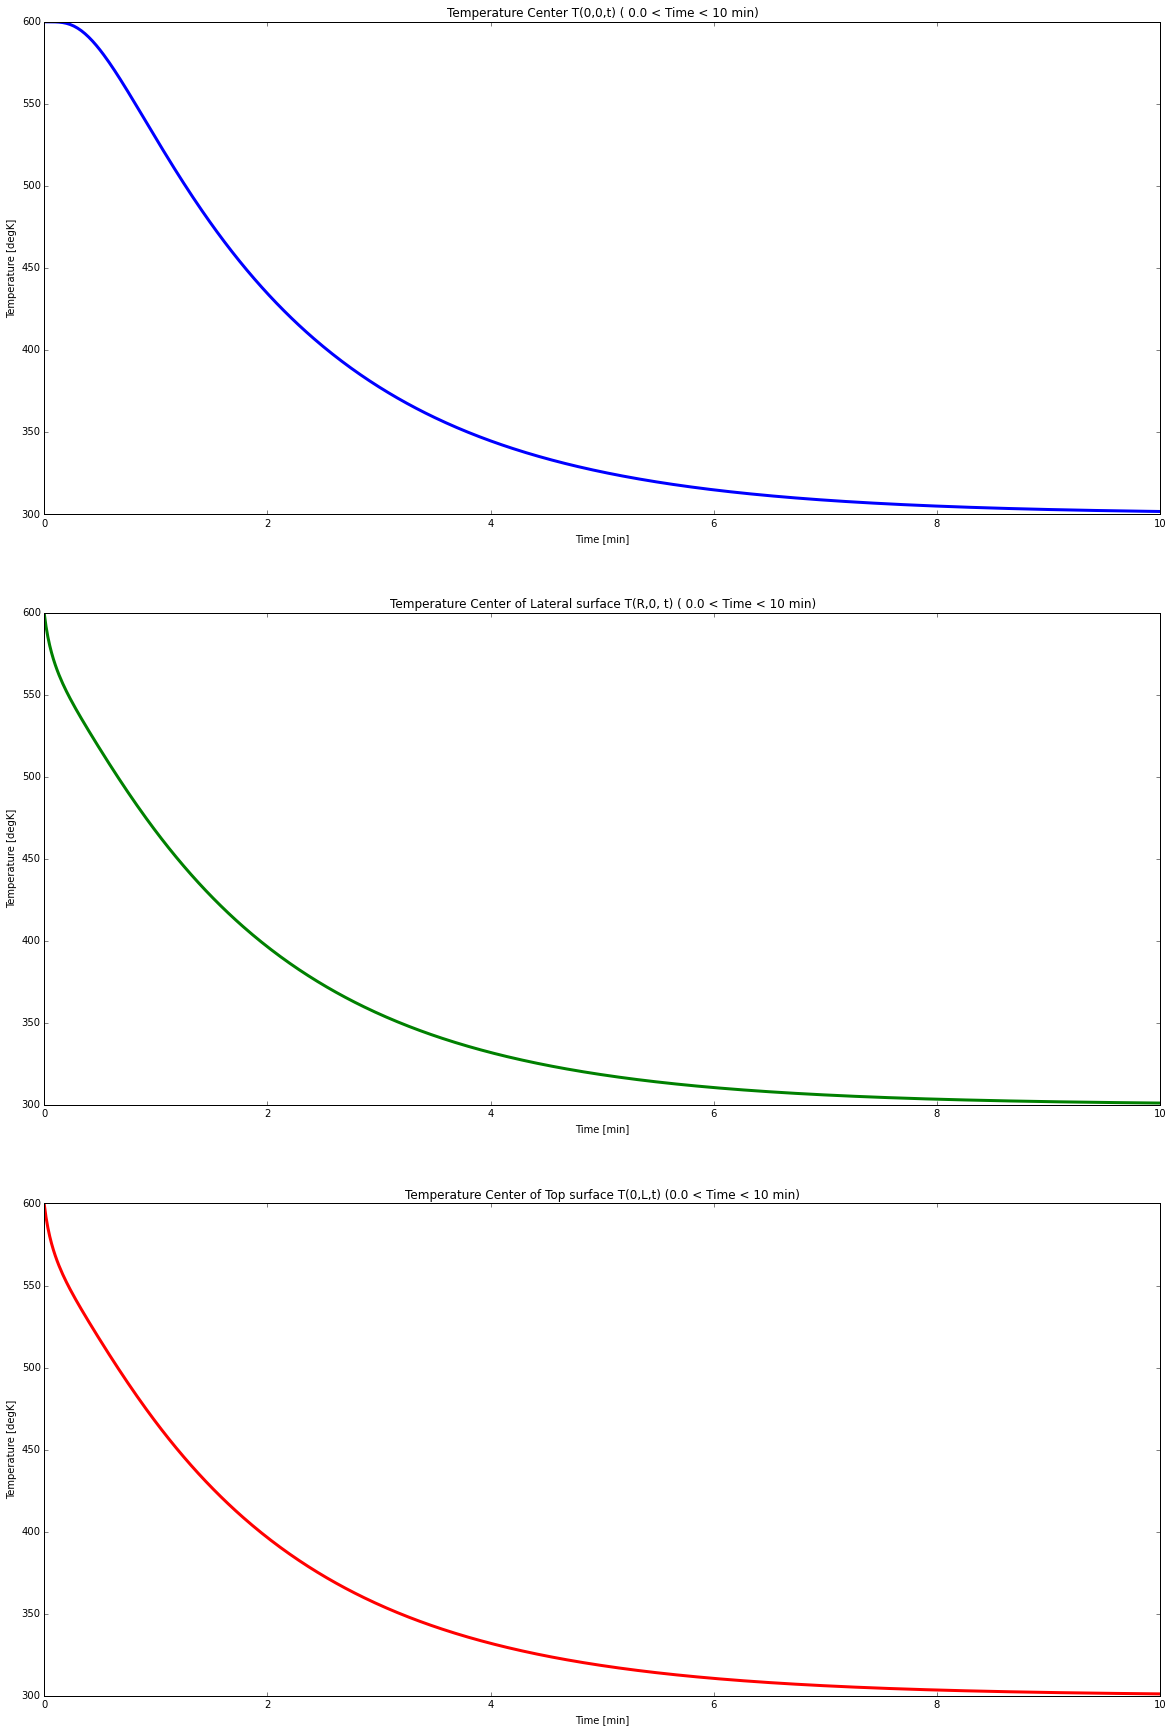

In [57]:
from matplotlib.pyplot import plot, show,legend,xlabel, ylabel, title, figure

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

# imports specific to the plots in this example
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data


%matplotlib inline
# Twice as wide as it is tall.
fig = plt.figure(figsize=(20,30))

ax = fig.add_subplot(3, 1, 1)
ax.plot(times/60, T_center, '-b',label='center', lw=3)
ax.set_title('Temperature Center T(0,0,t) ( 0.0 < Time < 10 min)')
ax.set_xlabel('Time [min]')
ax.set_ylabel('Temperature [degK]')
#ax.legend(loc=0)

ax1 = fig.add_subplot(3, 1, 2)
ax1.plot(times/60, T_center_of_lateral_surface, '-g', lw=3)
ax1.set_title('Temperature Center of Lateral surface T(R,0, t) ( 0.0 < Time < 10 min)')
ax1.set_xlabel('Time [min]')
ax1.set_ylabel('Temperature [degK]')
#ax1.legend(loc=0)

ax2 = fig.add_subplot(3, 1, 3)
ax2.plot(times/60, T_center_of_top_surface,'-r', lw=3)
ax2.set_title('Temperature Center of Top surface T(0,L,t) (0.0 < Time < 10 min)')
ax2.set_xlabel('Time [min]')
ax2.set_ylabel('Temperature [degK]')

plt.show()


# (c) Temperature Profile at 3min

In [104]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import itertools
import numpy as np

x = np.linspace(0,lenght_x, number_of_cells_x+1)
y = np.linspace(0,lenght_y, number_of_cells_y+1)
z = np.linspace(0,lenght_z, number_of_cells_z+1)

def plot_cube(T, label):
    
    points = []
    for element in itertools.product(x, y, z):
        points.append(element)

    def f(vals): 
    
        i = int((vals[0]/lenght_x)*(number_of_cells_x-1))
        j = int((vals[1]/lenght_y)*(number_of_cells_y-1))
        k = int((vals[2]/lenght_z)*(number_of_cells_z-1))

        index = i + j*number_of_cells_y + k*number_of_cells_y*number_of_cells_z   
        
        return T[index]

    fxyz = map(f, points)
    
    xi, yi, zi = zip(*points)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    pl = ax.scatter(xi, yi, zi, c=fxyz, s=500.0, marker='s', alpha=1.0, cmap=cm.jet, antialiased=True )
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(' Temperature profile at ' + label)
    ax.view_init(elev=30., azim=-30.0)
    
    fig.colorbar(pl, shrink=0.5, aspect=10)
    
    plt.show()
        

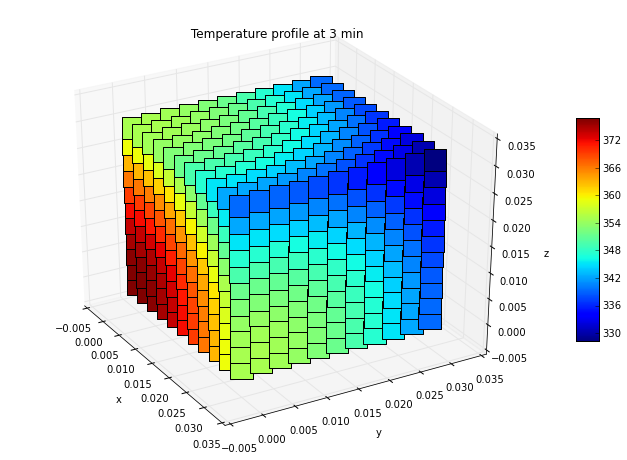

In [105]:
plot_cube(T3min, "3 min")


## (c2) Temperature Profile at 10min

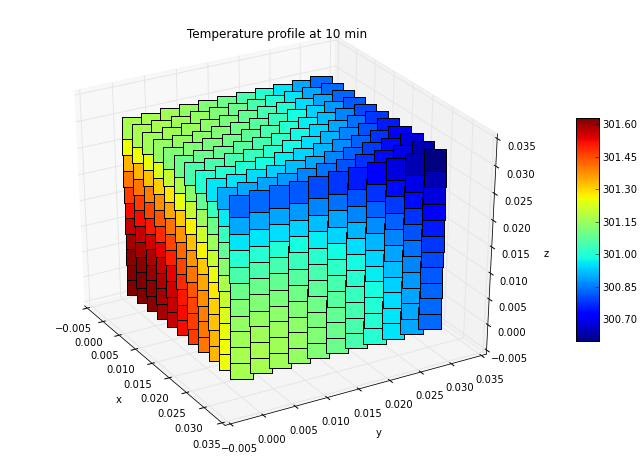

In [106]:
plot_cube(T, "10 min")